In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
import os
import sys
# sys.path.append("/Users/bovy/Repos/tgas-completeness/py/")
import tqdm
import numpy
from extreme_deconvolution import extreme_deconvolution
os.environ["GAIA_TOOLS_DATA"]="/Users/dkawata/work/obs/gaia_tools/data"
import gaia_tools.load, gaia_tools.xmatch
from galpy.util import bovy_plot, bovy_coords, save_pickles
import effsel # from tgas-completeness
from effsel import main_sequence_cut_r
%pylab inline
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter, FuncFormatter, LogFormatter
from matplotlib import gridspec
import copy
save_figures= False
numpy.random.seed(3)

Populating the interactive namespace from numpy and matplotlib


# The kinematics of local F stars

Load the TGAS and 2MASS data that we use, among other things, select F-type stars:

In [11]:
# Load TGAS and 2MASS
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
dm= -5.*numpy.log10(tgas['parallax'])+10.
mj= twomass['j_mag']-dm

Load the dwarf locus and select TGAS F-type stars with good parallaxes:

In [12]:
# Select F stars
sp= effsel.load_spectral_types()
sptype= 'F'
jkmin= (sp['JH']+sp['HK'])[sp['SpT']=='%s0V' % sptype]
if sptype == 'M':
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s5V' % sptype]
else:
    jkmax= (sp['JH']+sp['HK'])[sp['SpT']=='%s9V' % sptype]
jmin= main_sequence_cut_r(jkmax)
jmax= main_sequence_cut_r(jkmin)
good_plx_indx= (tgas['parallax']/tgas['parallax_error'] > 10.)*(jk != 0.)
good_sampling= good_plx_indx*(jk > jkmin)*(jk < jkmax)\
                *(mj < main_sequence_cut_r(jk,tight=False,low=True))\
                *(mj > main_sequence_cut_r(jk,tight=False))
print("Found %i F stars in TGAS with good parallaxes" % (numpy.sum(good_sampling)))
tgas= tgas[good_sampling]
twomass= twomass[good_sampling]
jk= jk[good_sampling]
dm= dm[good_sampling]
mj=mj[good_sampling]

Found 103603 F stars in TGAS with good parallaxes


In [13]:
rave_cat= gaia_tools.load.rave()
m1,m2,sep= gaia_tools.xmatch.xmatch(rave_cat,tgas,colRA1='RAdeg',colDec1='DEdeg',colRA2='ra',colDec2='dec',
                                    epoch1=2000.,epoch2=2015.,swap=True)
rave_cat= rave_cat[m1]
tgas= tgas[m2]
twomass= twomass[m2]
jk= jk[m2]
dm= dm[m2]
mj= mj[m2]
# Exclude stars with |b| <= 25
indx= numpy.fabs(tgas['b']) > 25.
rave_cat= rave_cat[indx]
tgas= tgas[indx]
twomass= twomass[indx]
jk= jk[indx]
dm= dm[indx]
mj= mj[indx]
print("Found %i F stars in TGASxRAVE with good parallaxes" % (len(tgas)))

Found 10509 F stars in TGASxRAVE with good parallaxes


In [18]:
rave_cat['distance']= rave_cat['distance']/1000.
rave_cat['edistance']= rave_cat['edistance']/1000.
tgas['parallax'][tgas['parallax_error']/tgas['parallax'] > 0.1]= 0.001 # Make sure these get taken out by the distance cut
rave_cat['distance'][rave_cat['distance'] == 0.]= 1./tgas['parallax'][rave_cat['distance'] == 0.]
rave_cat['edistance'][rave_cat['distance'] == 0.]= rave_cat['distance'][rave_cat['distance'] == 0.]\
                     *tgas['parallax_error'][rave_cat['distance'] == 0.]/tgas['parallax'][rave_cat['distance'] == 0.]
tgas_distance=1.0/tgas['parallax']
tgas_edistance=tgas['parallax_error']/(tgas['parallax']**2)

Note that we use TGAS parallax and parallax errors for distance and distance errors.

In [19]:
# Compute XYZUVW for overlap sample using TGAS distance
lb= bovy_coords.radec_to_lb(tgas['ra'],tgas['dec'],degree=True,epoch=None)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],tgas_distance,degree=True)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(tgas['pmra'],tgas['pmdec'],
                                          tgas['ra'],tgas['dec'],degree=True,epoch=None)
vxyz= bovy_coords.vrpmllpmbb_to_vxvyvz(rave_cat['HRV'],pmllbb[:,0],pmllbb[:,1],
                                       XYZ[:,0],XYZ[:,1],XYZ[:,2],
                                       XYZ=True,degree=True)

In [20]:
nmc= 1001
lbtile= numpy.tile(lb,(nmc,1))
XYZ_sam= bovy_coords.lbd_to_XYZ(lbtile[:,0],lbtile[:,1],
                                (numpy.atleast_2d(tgas_distance).T\
                                     +numpy.random.normal(size=nmc)\
                                 *numpy.atleast_2d(tgas_edistance).T).T.flatten(),degree=True)
ratile= numpy.tile(tgas['ra'],(nmc,1)).flatten()
dectile= numpy.tile(tgas['dec'],(nmc,1)).flatten()
pmllbb_sam= bovy_coords.pmrapmdec_to_pmllpmbb((numpy.atleast_2d(tgas['pmra']).T+numpy.random.normal(size=nmc)\
                                                  *numpy.atleast_2d(tgas['pmra_error']).T).T.flatten(),
                                              (numpy.atleast_2d(tgas['pmdec']).T+numpy.random.normal(size=nmc)\
                                                  *numpy.atleast_2d(tgas['pmdec_error']).T).T.flatten(),
                                              ratile,dectile,degree=True,epoch=None)
vxyz_sam= bovy_coords.vrpmllpmbb_to_vxvyvz((numpy.atleast_2d(rave_cat['HRV']).T\
                                               +numpy.random.normal(size=nmc)\
                                               *numpy.atleast_2d(rave_cat['eHRV']).T).T.flatten(),
                                           pmllbb_sam[:,0],pmllbb_sam[:,1],
                                           XYZ_sam[:,0],XYZ_sam[:,1],XYZ_sam[:,2],
                                           XYZ=True,degree=True)
vxyz_sam= vxyz_sam.reshape((nmc,len(tgas),3))
vxyz_err= numpy.std(vxyz_sam,axis=0)
vxyz_mean= numpy.mean(vxyz_sam,axis=0)

The distribution of uncertainties in $v_z$ is:

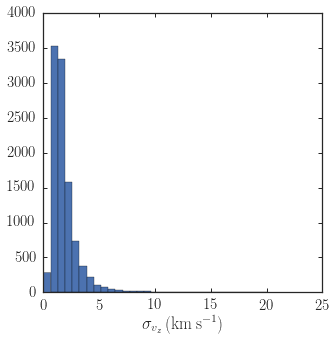

In [21]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
_= hist(vxyz_err[:,2],bins=31,range=[0.,20.])
xlabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The vertical velocity distribution is:

/Users/dkawata/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  from ipykernel import kernelapp as app

('lnL', -4.0974086750587)
('amp, mean, std. dev.', array([ 0.31157104,  0.68437484,  0.00405413]), array([ -9.04367646,  -6.32713532, -14.75582498]), array([  20.07190988,   10.36725006,  365.15448601]))


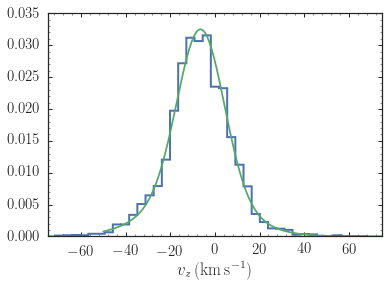

In [27]:
figsize(6,4)
indx= (True-numpy.any(numpy.isnan(vxyz),axis=1))\
    *(rave_cat['distance'] < 0.7)\
    *(numpy.fabs(XYZ[:,2]) < .4)\
    *(numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.) < 0.2)\
    *(True-numpy.isnan(vxyz_err[:,2]))
_= bovy_plot.bovy_hist(vxyz[indx,2],bins=41,range=[-75.,75.],
                       histtype='step',lw=2.,normed=True)
# Fit with mix of two Gaussians
ydata= numpy.atleast_2d(vxyz[indx,2]).T
ycovar= vxyz_err[indx,2]**2.
ngauss= 3
initamp= numpy.ones(ngauss)/ngauss
m= numpy.median(vxyz[indx,2])
s= 1.4826*numpy.median(numpy.fabs(vxyz[indx,2]-m))
initmean= []
initcovar= []
for ii in range(ngauss):
    initmean.append(m+numpy.random.normal()*s)
    initcovar.append(4.*s**2.)
initmean= numpy.array([initmean]).T
initcovar= numpy.array([[initcovar]]).T
print("lnL",extreme_deconvolution(ydata,ycovar,initamp,initmean,initcovar))
xs= numpy.linspace(-50.,50.,1001)
ys= numpy.sum(numpy.atleast_2d(initamp/numpy.sqrt(initcovar[:,0,0])).T\
              *numpy.exp(-0.5*(xs-numpy.atleast_2d(initmean[:,0]).T)**2./numpy.atleast_2d(initcovar[:,0,0]).T),axis=0)\
            /numpy.sqrt(2.*numpy.pi)
plot(xs,ys)
print("amp, mean, std. dev.",initamp,initmean[:,0],numpy.sqrt(initcovar[:,0,0]))
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

The distribution of $(v_z,\sigma_{v_z})$:

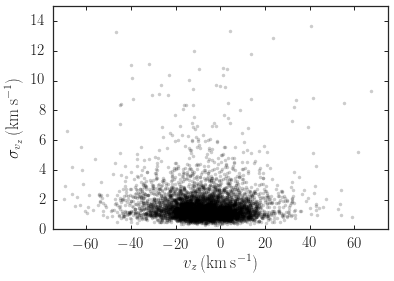

In [23]:
plot(vxyz[indx,2],vxyz_err[indx,2],'k.',alpha=0.2)
xlim(-75.,75.)
ylim(0.,15.)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
ylabel(r'$\sigma_{v_z}\,(\mathrm{km\,s}^{-1})$')

The $(z,v_z)$ distribution for this sample:

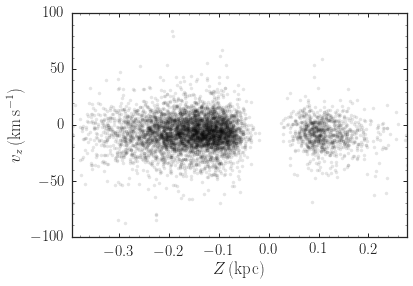

In [24]:
bovy_plot.bovy_plot(XYZ[indx,2],vxyz[indx,2],'k.',alpha=0.1,
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$v_z\,(\mathrm{km\,s}^{-1})$')